### COMSM0140: Internet Economics and Financial Technology 2023. Main coursework.

### Imran Zamin Ali

## Initial Setup

### Imports

In [1]:
# Uncomment if not installed or up to date
#!pip install pingouin
#!pip install --upgrade pingouin

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from BSE import market_session
from os import cpu_count
from cwhelpers import get_traders_specs, part_a, part_b, part_c, part_d1, run_experiment_old
from plot import plot_sup_dem

#### Statistics

We're going to be doing a lot of experiments and statistical tests. Therefore we can make our lives a bit easier by automating them. First lets setup our statistics. Each time we a trade is made it affects the market and how much profit the proceeding traders make. This means that the samples generated **within** each market session is paired rather than independent.
Our statistics function determines which test(s) to use based on the flowchart below. The function first checks the normality of the data, with the Shapiro-Wilk test, as well as the number of distrubutions. Using these paramters either a paired t-test, wilcoxon step rank, repeated measures ANOVA or friedman test is used. For the RM ANOVA there is another assumption of sphericity (https://www.jci.org/articles/view/171058) that needs to be tested for using the mauchly test and can be corrected if needed. In the cases where we have more than two distrubutions and we reject $H_0$, then we need to carry out post-hoc tests to decide which distrubitions are different. I am using pairwise paired t-tests or wilcoxon step rank tests based on our normality assumption. If you recall lab 3, using multiple 2 distrubution tests leads to a higher probability of rejecting $H_0$ as our type 1 error rate is higher. To deal with this you can use a correction such as Holmes-Bonferroni (https://www.statisticshowto.com/holm-bonferroni-method/).

To read up on the which tests I used and why please refer to '100 Statistical Tests' by Gopal K Kanji (LINK), which was mentioned in Dave Cliff's leture on empirical methods. You can see how to implement them by reffering to the scipy (https://docs.scipy.org/doc/scipy/) and pingouin (https://pingouin-stats.org/build/html/index.html) documentation. 

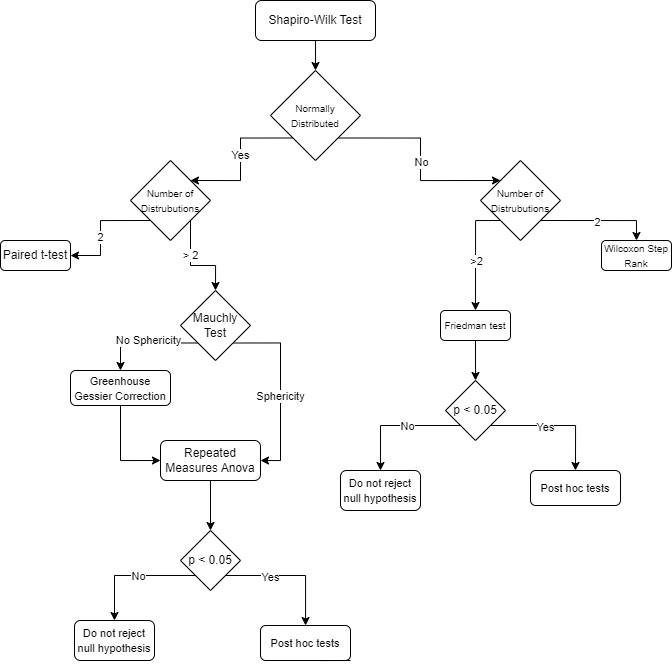

#### Setting up our market

For parts A to C we are using the market defined by Chart 4 in the Journal of Political Economy (Smith, 1962). Therefore we can define and display the supply and demand here. We'll set the market to run for 5 minutes with an order interval of 10 seconds.

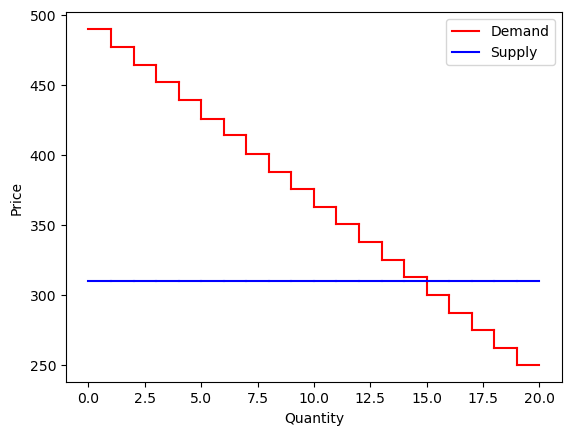

In [3]:
sup_range = (310, 310)
dem_range = (250, 490)
num_buyers = 20
num_sellers = 20
stepmode = 'fixed'
start_time = 0
end_time = 60 * 15
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': stepmode}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': stepmode}]
order_interval = 30
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
              'interval': order_interval, 'timemode': 'periodic'}
verbose = False
dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
              'dump_avgbals': True, 'dump_tape': False}
initial_seed = 100
plot_sup_dem(num_sellers, [sup_range], num_buyers, [dem_range], stepmode)

Since the supply is perfectly elastic and there are equal numbers of buyers and sellers we only need to consider the buyers in our experiments.

#### Method

For parts A to C we run $n$ market sessions and collect the final average profit from each session. We then plot the appropriate graphs and run our tests.

## Part A

Let's setup the traders as mentioned in the brief and examine the results.

In [4]:
r = 50
r_vals = (r, 100 - r)
algos = ('SHVR', 'ZIC')
seller_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_sellers)
buyer_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_buyers)
traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
n_vals = [50, 500]
trial_id =  'trial'

,n,Trader ratio:,SHVR mean,SHVR std,ZIC mean,ZIC std,All normal,Test Name,P Value,Different populations
0,50,50:50,975.8510,181.556002,989.0230,184.268510,True,paired t-test,0.800054,False
1,500,50:50,976.8747,198.768965,988.5983,201.712264,True,paired t-test,0.512973,False


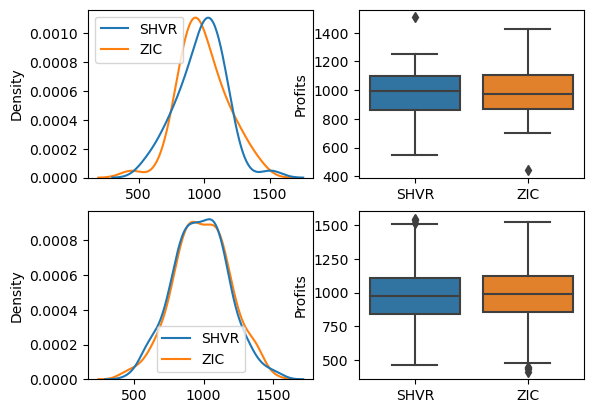

In [5]:
summary = part_a(n_vals, (start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed, r_vals)
display(summary)
plt.show()

For both n=50 and n=500 there isn't no significant difference in ZIC and SHVR profitability. The supply and demand graph shows us only 15 trades can happen per trading window. Therefore, we would expect the SHVRs to be more likely to trade than the ZICs. This should lead to the shavers performing better overall. However, competition amongst the SHVRS lowers profit made on each bid. Therefore, when looking at the in average profitabilty for ZIC and SHVR there is insufficent evidence to suggest a difference and we cannot reject $H_0$.

## Part B

We now introduce an imabalance of SHVRs and ZICs into the market going from 10% SHVR to 90%.

In [15]:
r_list = list(range(10, 91, 10))

,Trader ratio,SHVR mean,SHVR std,ZIC mean,ZIC std,All normal,Test Name,P Value,Different populations
0,10:90,1103.740000,541.272794,958.877778,62.642363,True,paired t-test,0.096134,False
1,20:80,1046.852500,357.667370,957.915000,90.860869,True,paired t-test,0.167114,False
2,30:70,1019.188333,287.971089,960.777143,124.914361,True,paired t-test,0.321971,False
3,40:60,996.661250,242.494520,968.753333,165.471356,True,paired t-test,0.630659,False
4,50:50,975.851000,181.556002,989.023000,184.268510,True,paired t-test,0.800054,False
5,60:40,968.605000,148.169235,1009.756250,226.081150,True,paired t-test,0.440524,False
6,70:30,975.367143,133.661725,1014.208333,313.613996,True,paired t-test,0.541998,False
7,80:20,957.006875,86.116779,1118.422500,347.101035,True,paired t-test,0.011239,True
8,90:10,964.000556,63.163605,1228.115000,571.430192,True,paired t-test,0.004956,True


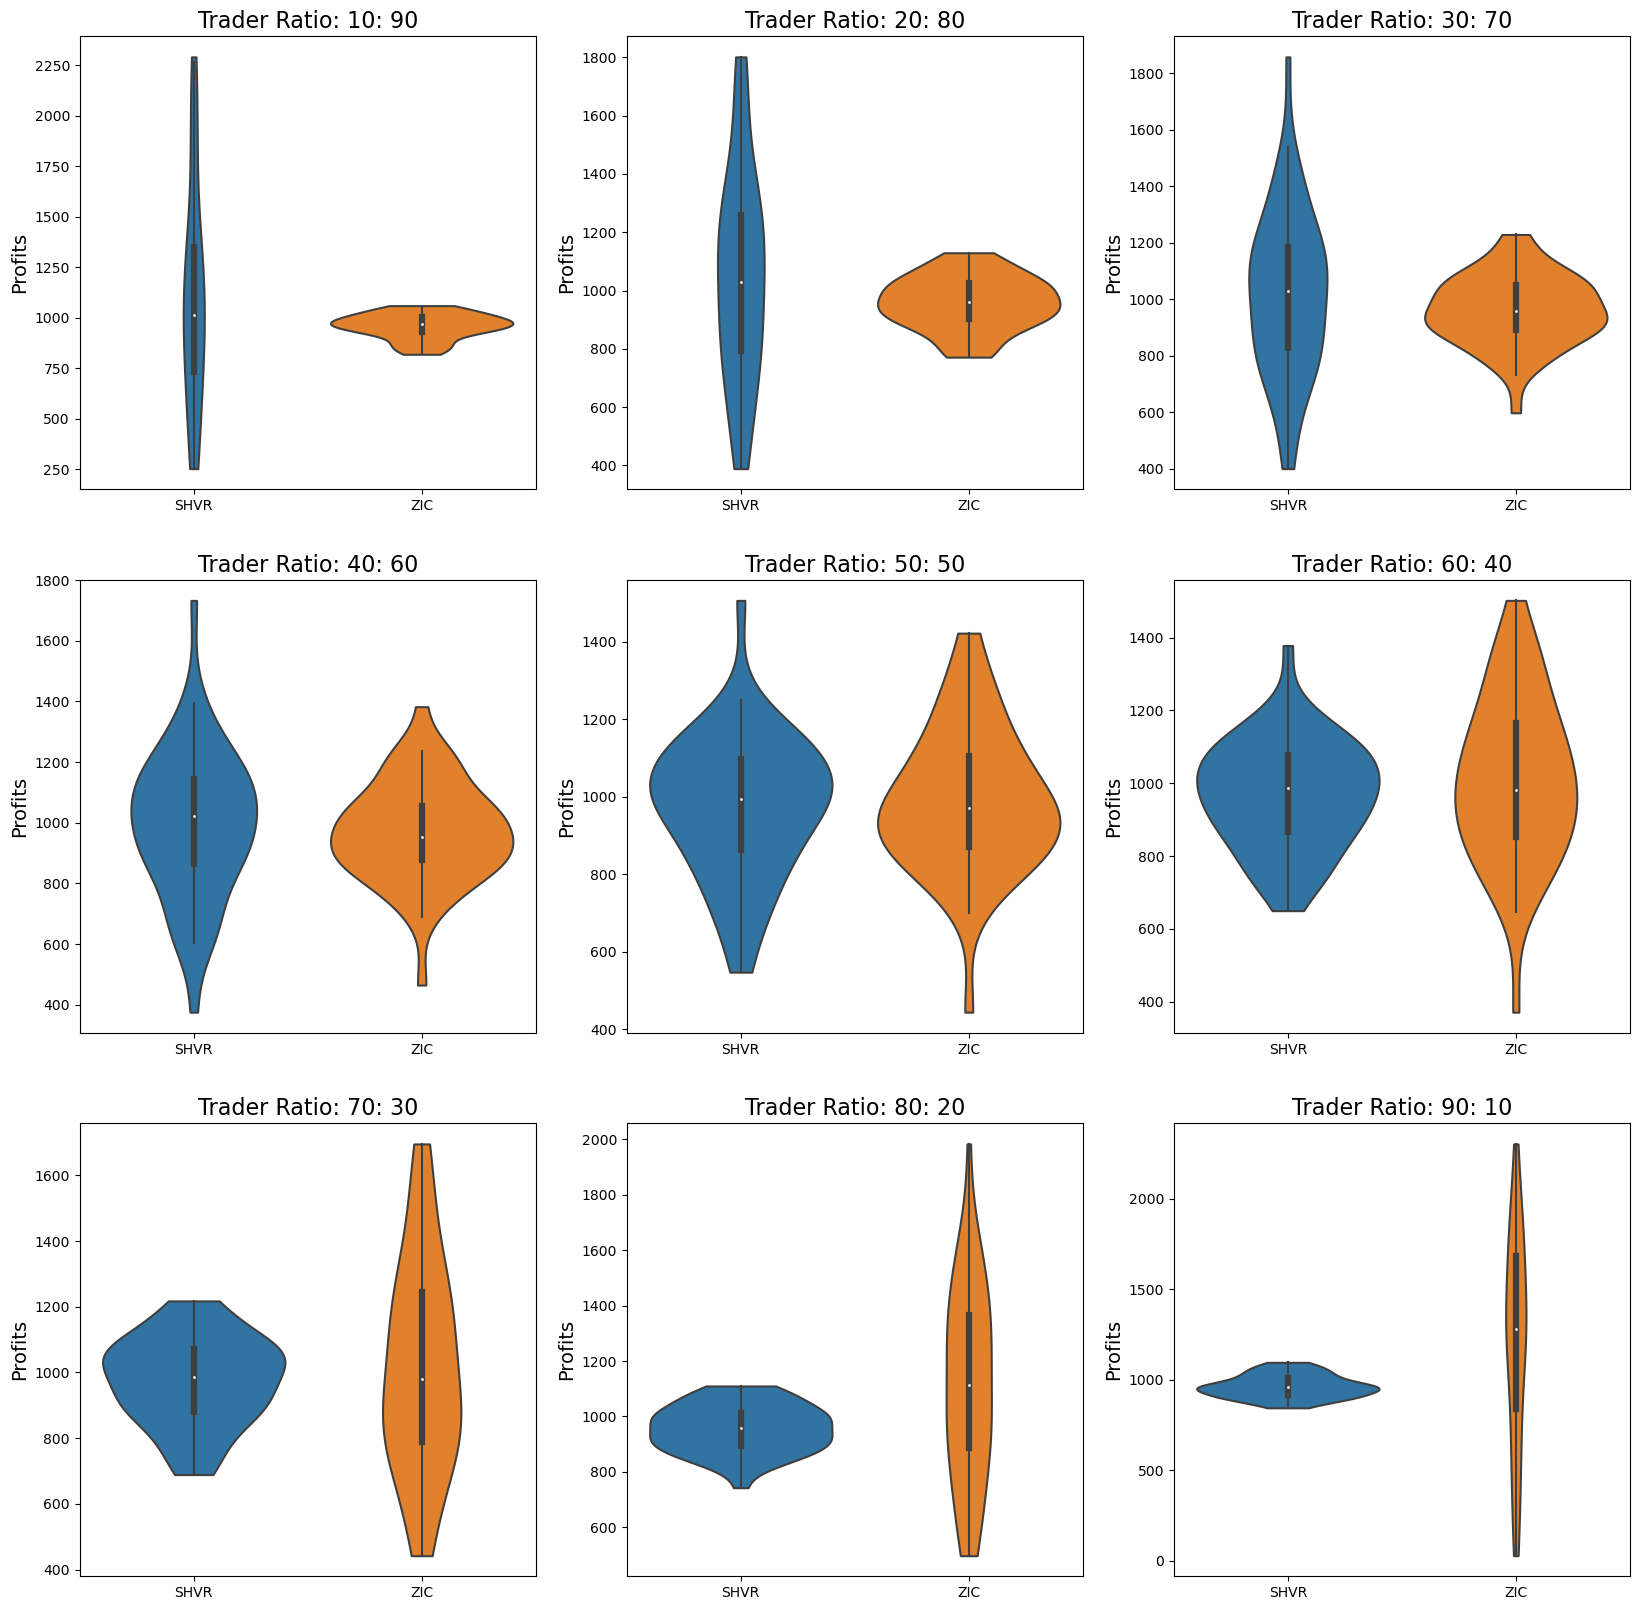

In [7]:
summary = part_b(50, [start_time, end_time, traders_specs, order_sched, dump_flags, verbose],r_list, algos, initial_seed)
display(summary)
plt.show()

The variance for traders with higher volumes to be lower because we are using the average profit and the extremes get cancelled out. As $R$ decreases, the SHVR distrubution becomes more positively skewed. This is because there are more ZICs in the market and so the shaving starts from a lower price. The ZIC distrubution becomes positively skewed as $R$ increases due to ZICS being less likely to be marginal traders. The statistical tests only reject the $H_0$ for $R>6$. Since t-test only uses the sample means, we don't need to do a one-tail follow up. Therefore we can say for $n=50$ and $R∈\{80,90\}$ there is sufficient evidence to say ZIC is more profitable than SHVR.

,Trader ratio,SHVR mean,SHVR std,ZIC mean,ZIC std,All normal,Test Name,P Value,Different populations
0,10:90,1066.665000,536.188910,963.530278,61.443103,False,Wilcoxon Signed Rank test,0.005719,True
1,20:80,1039.710000,361.958241,959.802812,92.213239,False,Wilcoxon Signed Rank test,0.001425,True
2,30:70,1005.800500,278.327458,966.498286,121.062090,True,paired t-test,0.028194,True
3,40:60,985.042500,230.491027,977.505250,155.740140,True,paired t-test,0.662689,False
4,50:50,976.874700,198.768965,988.598300,201.712264,True,paired t-test,0.512973,False
5,60:40,973.762000,162.378870,1000.698000,246.696143,True,paired t-test,0.141495,False
6,70:30,979.307000,133.576429,1003.971000,315.167930,True,paired t-test,0.219610,False
7,80:20,979.475125,101.557545,1026.896750,409.812386,True,paired t-test,0.038620,True
8,90:10,985.096778,67.989438,1032.088500,617.231191,False,Wilcoxon Signed Rank test,0.199337,False


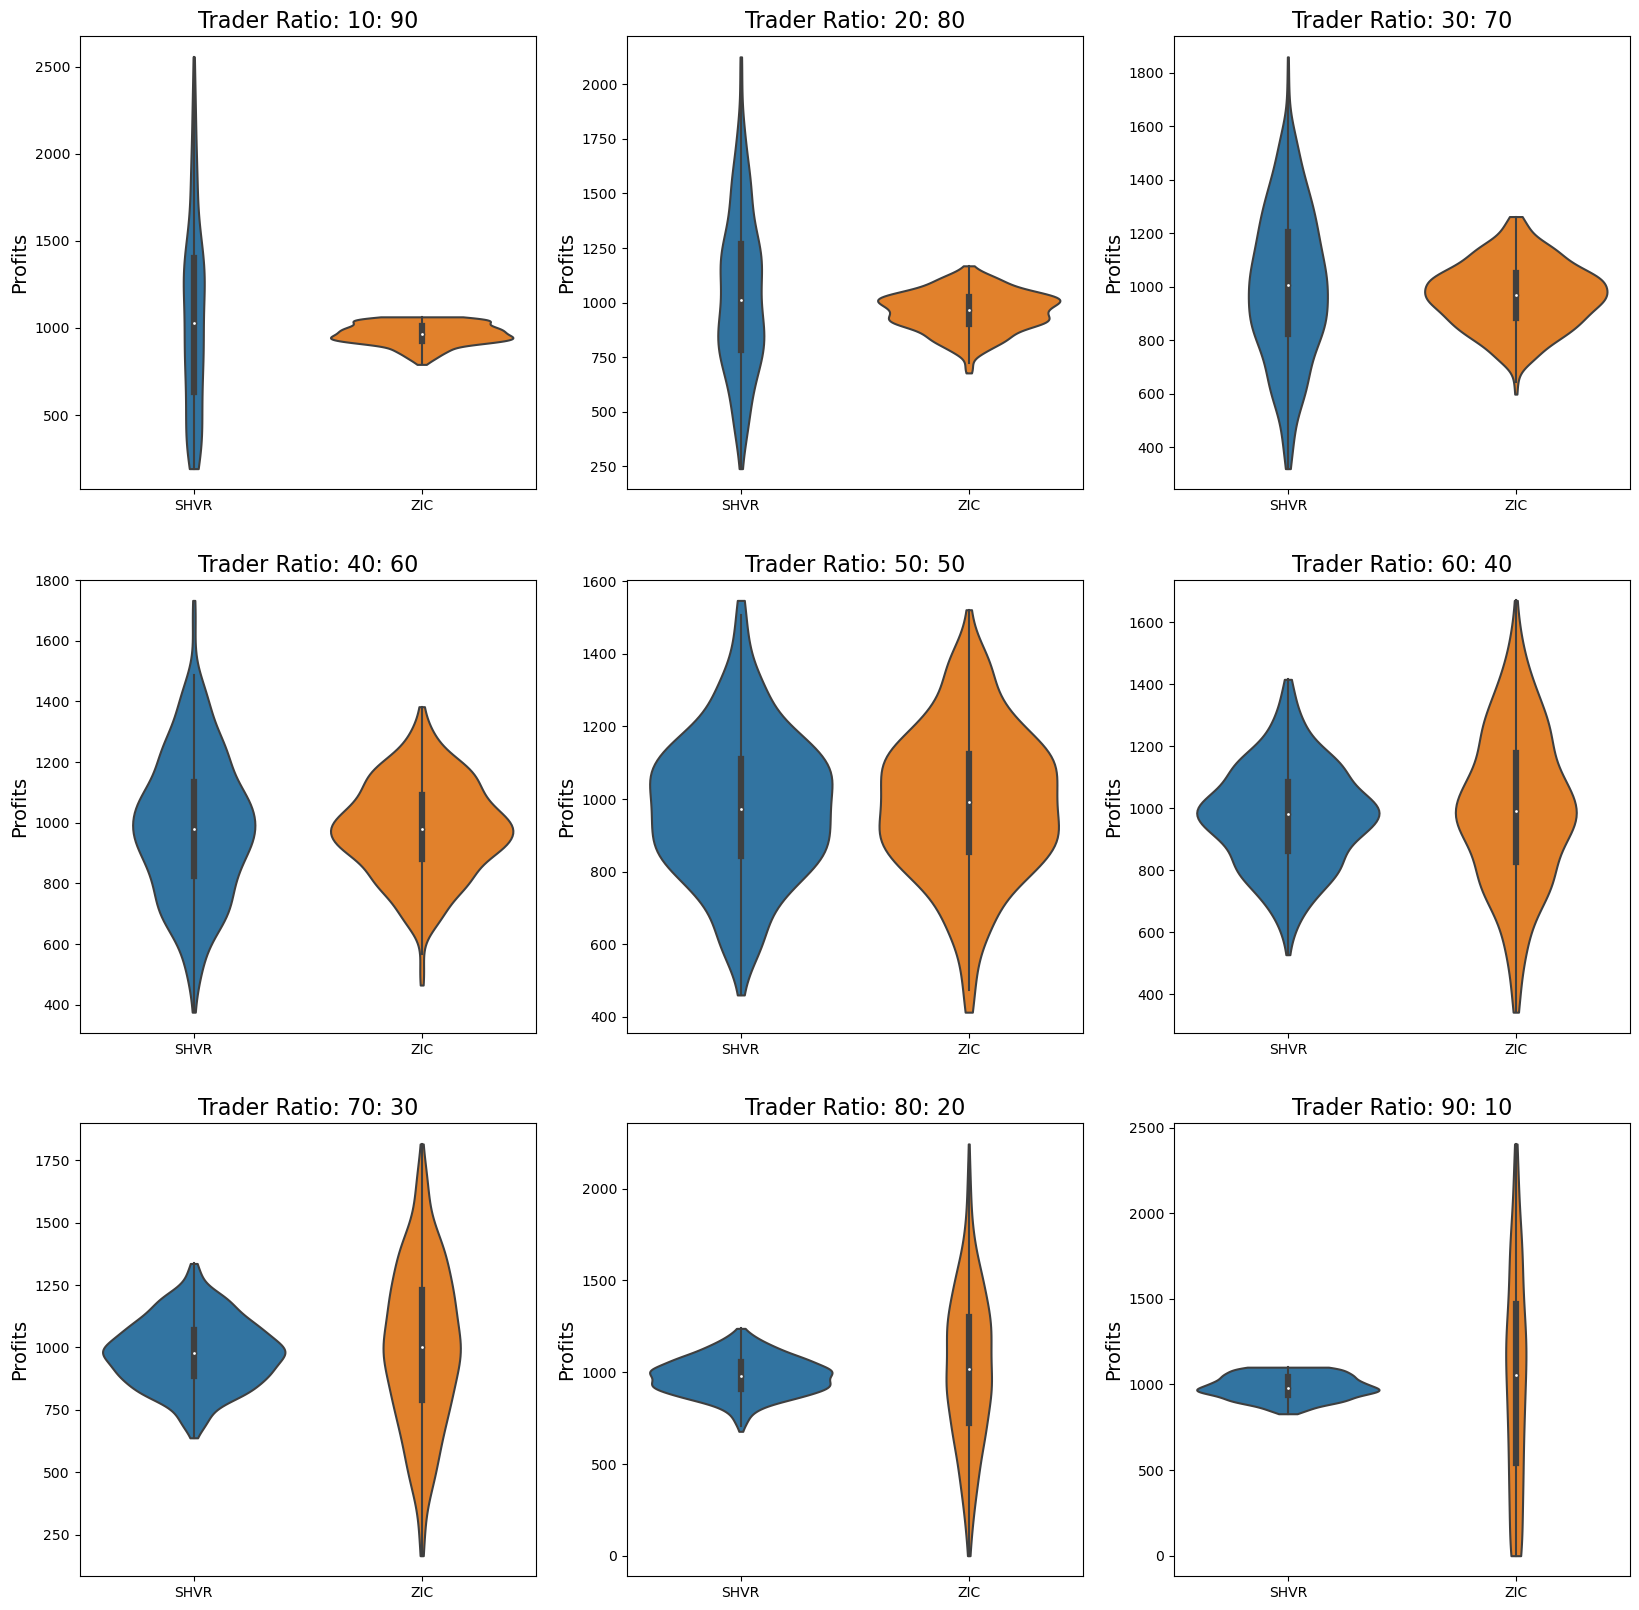

In [8]:
summary = part_b(500, [start_time, end_time, traders_specs, order_sched, dump_flags, verbose],r_list, algos, initial_seed)
display(summary)
plt.show()

The data for $n=500$ tends to follow the same trend as $n=50$. Furthermore, now that we have more data, there is a better representation of the population and our statistics will have a higher precision. We now see that there is sufficient evidence to reject $H_0$ for our normality test for $R∈\{10,20,90\}$. Also for $R∈\{10,20,30\}$ there is sufficient evidence to reject $H_0$ and that SHVR is more profitable than ZIC. Whilst for $R=80$ there is sufficient evidence to reject $H_0$ as ZIC is more profitable than SHVR.

## Part C

In [5]:
algos = ('SHVR', 'GVWY', 'ZIC', 'ZIP')

,Trader ratio,GVWY mean,GVWY std,SHVR mean,SHVR std,ZIC mean,ZIC std,ZIP mean,ZIP std,All normal,Test Name,P Value,Different populations,"GVWY, SHVR","GVWY, ZIC","GVWY, ZIP","SHVR, ZIP","ZIC, ZIP"
0,25:25:25:25,934.9124,311.213079,992.371,335.949976,1015.028,331.772554,469.361,161.759317,False,Friedman Test,2.870080e-124,True,0.033733,0.002631,7.888457e-71,1.744198e-71,3.016190e-73


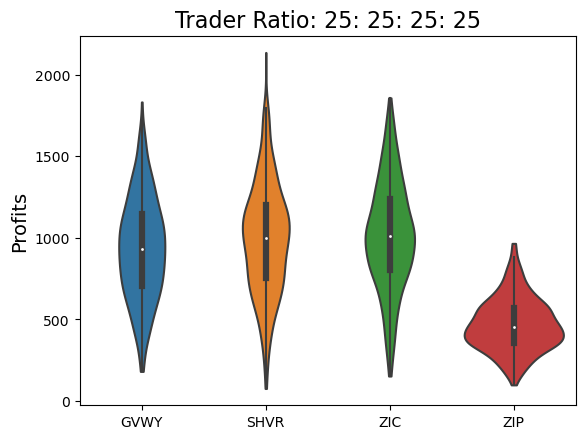

In [10]:
r_vals = [25, 25, 25, 25]
summary = part_c(500, [start_time, end_time, traders_specs, order_sched, dump_flags, verbose],r_vals, algos, initial_seed)
display(summary)
plt.show()

When there are equal number of traders in the market, there is sufficient evidence to suggest that ZIP performs the worst by just looking at the violin plot because $\bar{x}_{ZIP}+s_{ZIP}<\bar{x}_{t}-s_{t}$ for all other traders. The statistical tests rejects the initial $H_0$ that the profits are from the same distrubution. The post-hoc wilcoxon step rank test further identifies that GVWY and ZIP are from unique populations but cannot distinguish between SHVR and ZIC. SHVR and ZIC statistically generate more profit with these conditions.

,Trader ratio,GVWY mean,GVWY std,SHVR mean,SHVR std,ZIC mean,ZIC std,ZIP mean,ZIP std,All normal,Test Name,P Value,Different populations,"GVWY, SHVR","GVWY, ZIC","GVWY, ZIP","SHVR, ZIC","SHVR, ZIP","ZIC, ZIP"
0,40:20:20:20,916.61350,327.180540,987.40850,244.342469,1043.96500,383.718787,544.71875,215.490224,False,Friedman Test,1.969378e-97,True,0.002668,0.000003,9.724187e-56,0.044104,1.725673e-64,1.132227e-60
1,20:20:20:40,912.09375,360.589851,995.32050,397.906322,995.26000,392.533247,364.34125,116.001251,False,Friedman Test,1.246773e-137,True,0.013028,0.013028,3.565019e-76,NaN,1.903295e-76,4.122212e-76
2,20:20:40:20,919.57725,365.427068,993.39725,403.055688,994.37700,233.397191,644.29300,246.427570,False,Friedman Test,1.175896e-51,True,0.017116,0.001475,2.666790e-27,NaN,6.396708e-37,2.879944e-50
3,20:40:20:20,935.40525,212.155602,971.75500,406.230961,1058.92475,389.181608,465.49675,176.749945,False,Friedman Test,4.839467e-120,True,NaN,0.000001,5.404829e-78,0.013730,3.318205e-62,2.723863e-71


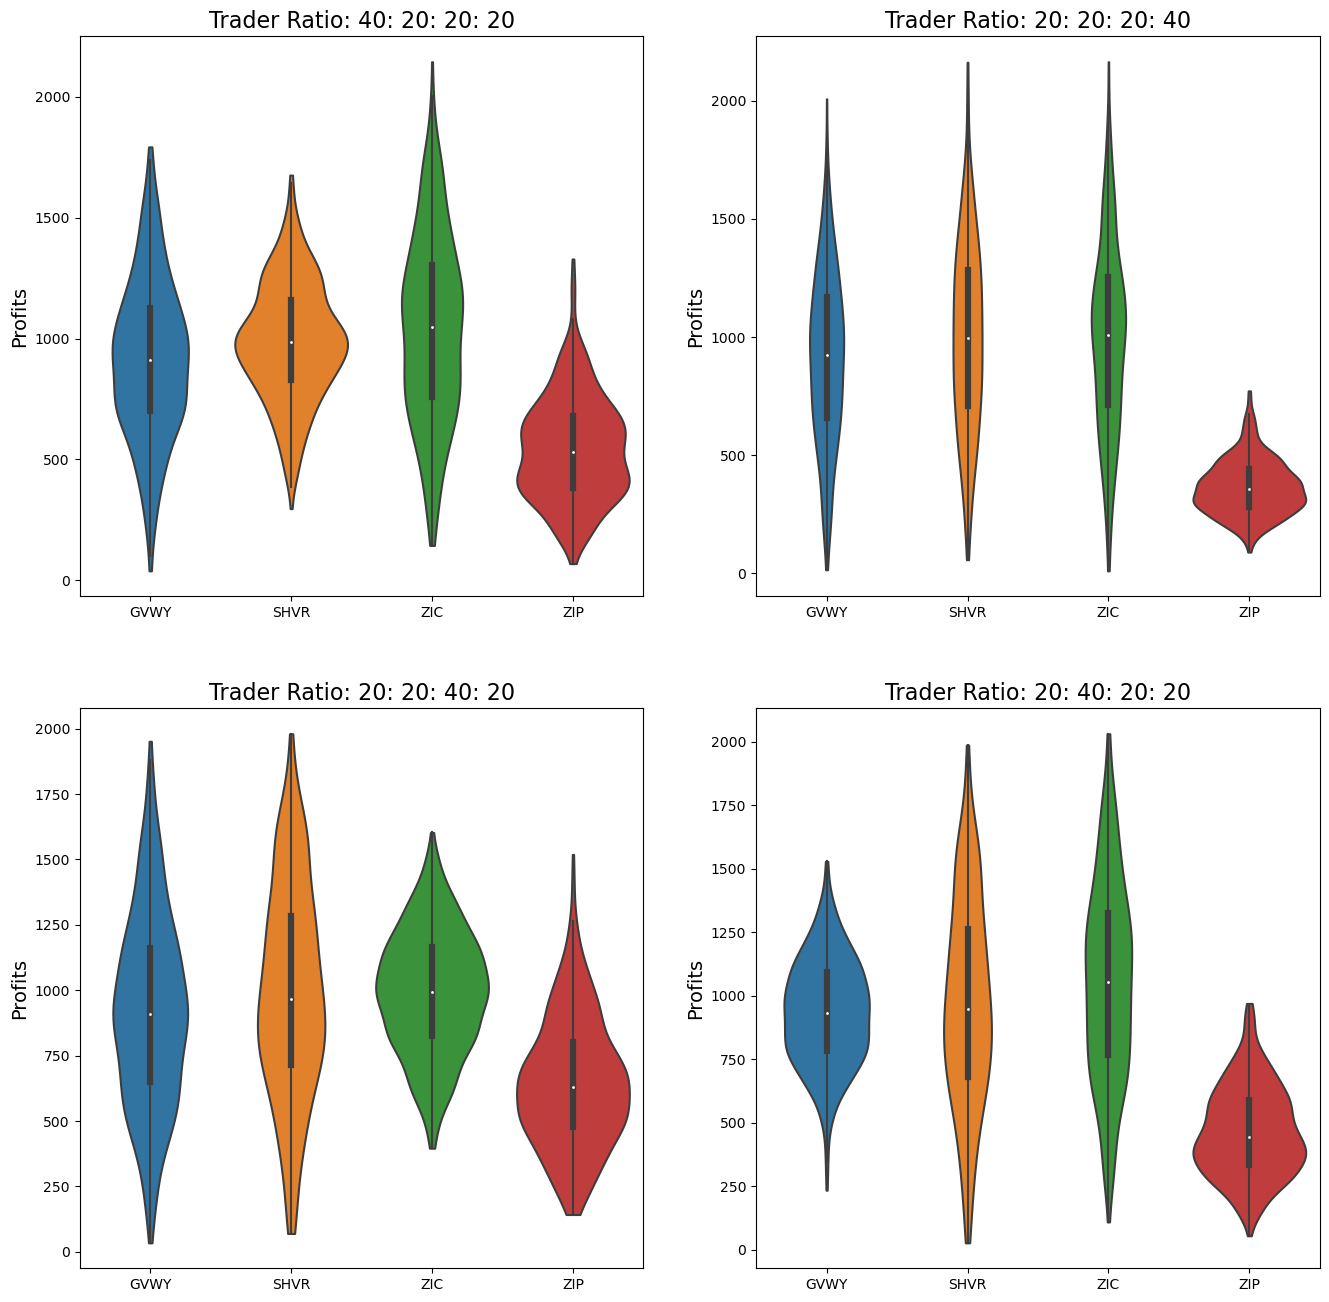

In [11]:
r_vals = [40,20,20,20]
summary = part_c(500, [start_time, end_time, traders_specs, order_sched, dump_flags, verbose],r_vals, algos, initial_seed)
display(summary)
plt.show()

ZIC appears to be the least consistent which makes sense since its bids are and therefore the successful bids are based on what other traders do. 20:20:40:40 seems to be the most interesting. A large amount of ZICs means it has lower variance. The GVWYs force the SHVR to make minimal profit. This finally gives a chance to be more successful, hence why it becomes more positively skewed. Once again, only SHVR and ZIC do not sufficiently differ to statistically say with confident that their profits differ. ZIP still performs the worst. When SHVR and ZIC profits come from different populations SHVR performs the best. Otherwise SHVR and ZIC bother perform better than the others.

,Trader ratio,GVWY mean,GVWY std,SHVR mean,SHVR std,ZIC mean,ZIC std,ZIP mean,ZIP std,All normal,Test Name,P Value,Different populations,"GVWY, ZIC","GVWY, ZIP","SHVR, ZIP","ZIC, ZIP","GVWY, SHVR"
0,10:30:30:30,911.022500,273.230925,950.032500,584.439945,1007.538333,304.128805,382.939833,132.360647,False,Friedman Test,3.874122e-128,True,0.000032,8.363495e-80,1.128993e-56,1.660065e-80,NaN
1,30:30:30:10,917.982167,261.272121,1005.379333,304.907994,1019.162500,304.146382,612.416500,332.421591,False,Friedman Test,1.313780e-58,True,0.000014,9.110397e-36,2.642457e-46,3.822586e-45,0.000228
2,30:30:10:30,934.698000,279.386727,967.962833,287.272548,1041.783500,581.089260,444.545667,140.857976,False,Friedman Test,2.085118e-117,True,0.014264,4.509610e-77,4.509610e-77,2.505457e-57,NaN
3,30:10:30:30,895.678000,533.652535,985.847000,286.808762,981.906667,305.197282,517.937167,171.472527,False,Friedman Test,2.767190e-85,True,0.006827,5.890929e-34,2.231554e-70,3.556281e-68,0.006827


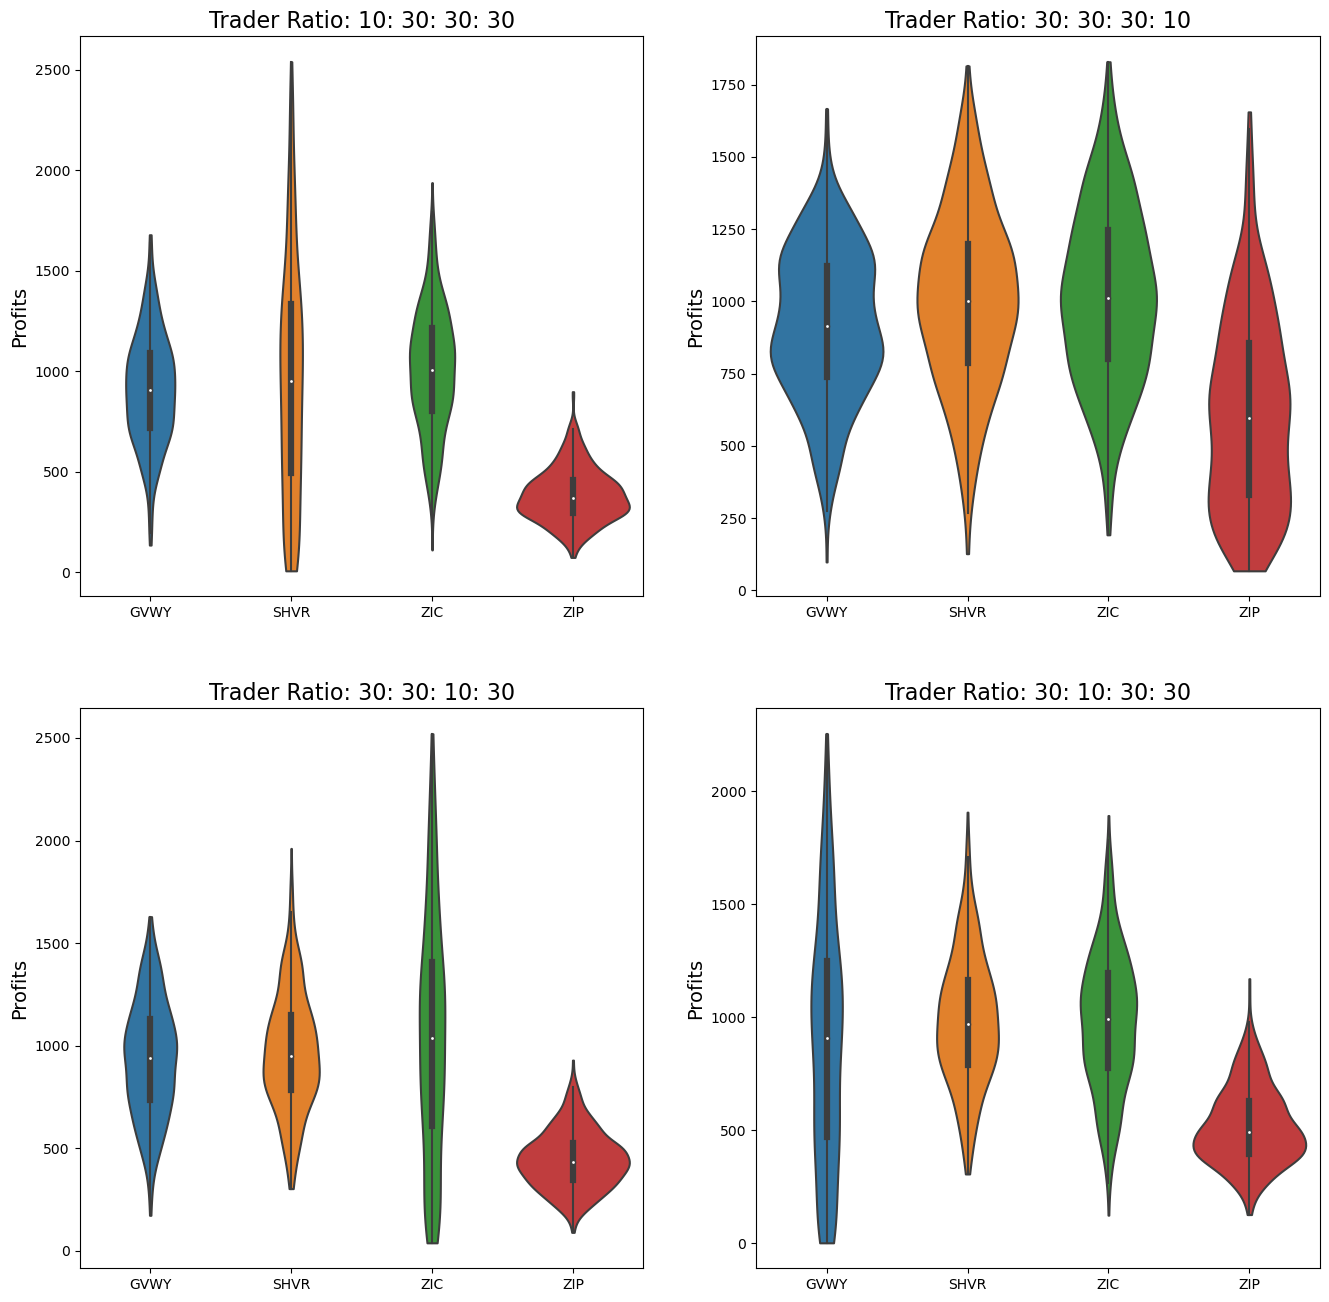

In [12]:
r_vals = [10, 30, 30, 30]
summary = part_c(500, [start_time, end_time, traders_specs, order_sched, dump_flags, verbose],r_vals, algos, initial_seed)
display(summary)
plt.show()

ZIP always performs the worst. For the post-hoc test $H_0$ was never rejected for SHVR and ZIC. An interesting relationship to point out is when $R_{GVWY}=10$, SHVR's performance severly declines as expected since it minimises the amount of profit SHVR can make per bid. Similarly when $R_{SHVR}=10$, GVWY's performance declines. This is a perfect example of the law of large numbers (https://www.probabilitycourse.com/chapter7/7_1_1_law_of_large_numbers.php) since the traders have similar behaviour. Once again SHVR and ZIC are dominant.

,Trader ratio,GVWY mean,GVWY std,SHVR mean,SHVR std,ZIC mean,ZIC std,ZIP mean,ZIP std,All normal,Test Name,P Value,Different populations,"GVWY, ZIC","GVWY, ZIP","SHVR, ZIC","SHVR, ZIP","ZIC, ZIP","GVWY, SHVR"
0,70:10:10:10,952.470500,534.938549,969.659643,131.218340,1101.649000,548.624650,744.3415,382.277614,False,Friedman Test,1.320722e-26,True,0.000109,4.691830e-11,0.000075,1.015803e-21,1.008645e-23,NaN
1,10:10:10:70,917.500000,580.577443,1017.473500,604.692252,1020.296000,582.747176,218.7735,99.243982,False,Friedman Test,1.169734e-111,True,0.038140,3.676332e-71,NaN,4.456470e-74,1.409989e-75,0.038140
2,10:10:70:10,863.569500,496.358976,1052.058500,558.246062,971.519786,121.421518,1040.6060,575.553919,False,Friedman Test,5.180491e-05,True,0.000075,3.049857e-05,NaN,NaN,NaN,0.000003
3,10:70:10:10,958.614786,116.069107,974.159000,569.195154,1090.396500,575.268153,499.9625,233.511583,False,Friedman Test,3.761869e-80,True,0.000201,6.495472e-77,0.018188,5.257506e-40,9.761178e-52,NaN


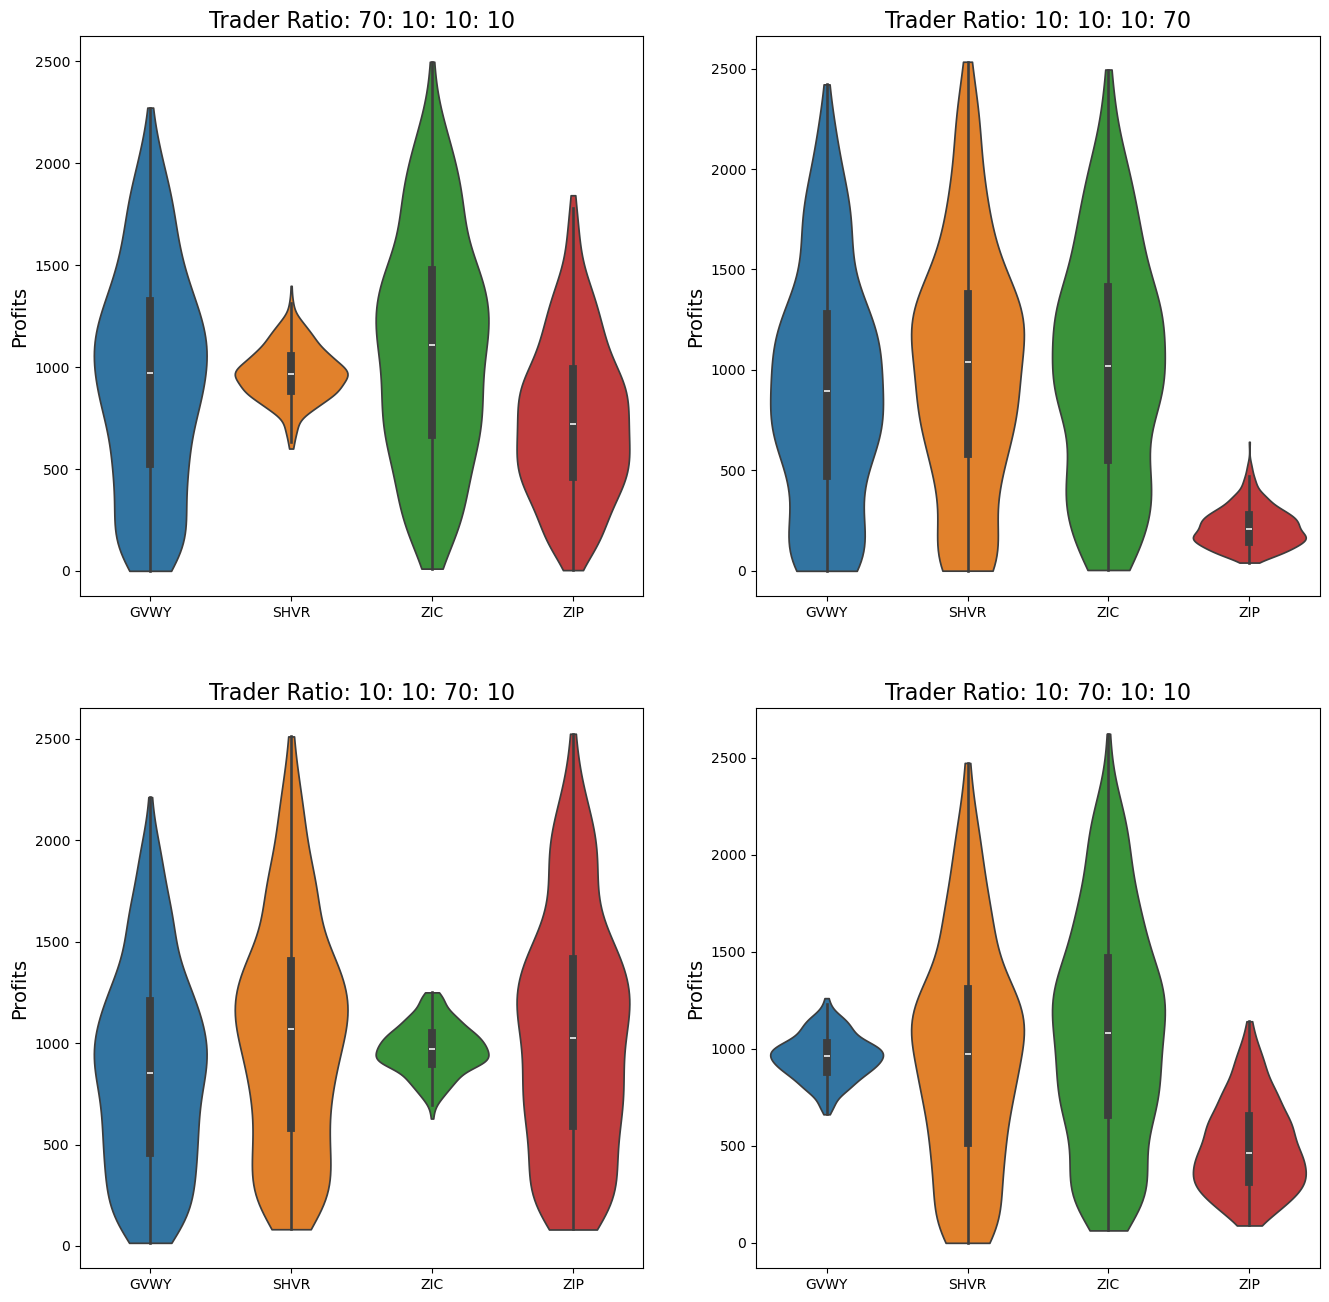

In [6]:
r_vals = [70,10,10,10]
summary = part_c(500, [start_time, end_time, traders_specs, order_sched, dump_flags, verbose],r_vals, algos, initial_seed)
display(summary)
plt.show()

Once again the law of large numbers and the central limit theorem reduces the variance of the trader for which $R=70$. The bottom left had the most interesting result where SHVR, ZIC and ZIP were indistinguishable from each other. This is because GVWY is lowering the profit margins which causes SHVR and ZIP to decrease theirs also. Therefore, for ZIC to trade the random bids have to be lower as well.

To summarise, for the majority of part C, SHVR and ZIC, were often statistically more profitable than GVWY and ZIP. This is because GVWY was designed to generate minimum profit and ZIP reacts the slowest to market changes as it tries to ensure a higher profit each bid. Whereas SHVR constantly attempts to undercut and make a trade. ZIC being random means it is not affected by others in the market hence why its central tendency is approximately the same througout.
Another point to mention is that all the distrubutions are positively skewed becasue of extra marginal traders which lowers the profit averages. This reduction is especially significant for lower values of $R$ as it affects the averages more, as shown in the final set of plots.

## Part D1

In [3]:
sup_range = (50, 75)
dem_range = (150, 125)
num_buyers = 10
num_sellers = 10
buyers = [('ZIC', 9), ('ZIPSH', 1,{'optimizer': 'ZIPSH', 'k': 4})]
sellers = [('ZIC', 10)]
traders_specs = {'sellers': sellers, 'buyers': buyers}
start_time = 0
end_time = 60 * 60 * 24 * 80
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]
order_interval = 15
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
              'interval': order_interval, 'timemode': 'periodic'}
dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': True,
              'dump_avgbals': False, 'dump_tape': False}
verbose = False
initial_seed = 100

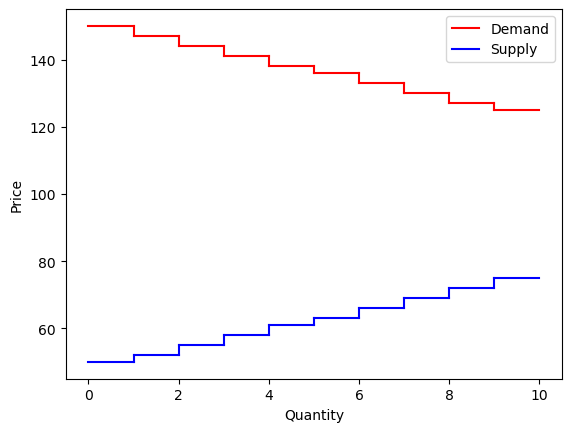

In [17]:
plot_sup_dem(num_sellers, [sup_range], num_buyers, [dem_range], 'fixed')

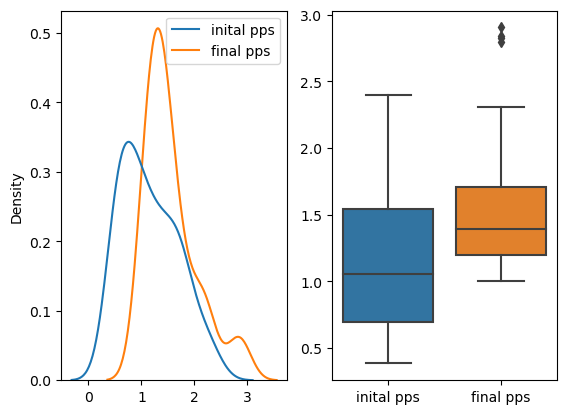

   inital pps normality  final pps normality  All normal  \
0              0.009443             0.000004       False   

                   Test Name       P Value  Different populations  
0  Wilcoxon Signed Rank test  3.915425e-10                   True  


In [3]:
zipsh_summary = part_d1(60, (start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)
display(zipsh_summary)
plt.show()

I changed the initial parameters to match those in the brief and ran 60 i.i.d. market sessions for 80 days so that I could make a fair comparison with my experiments in Part D2. Due to the evolution being stochastic I calculated the mean of the first 5 pps and the last 5 pps for each session to improve reliability. After running a Wilcoxon Sign Rank test I found there was sufficient evidence to reject $H_0$ and claim that the pps increased over the trading period. The scatterplot below shows 10 market sessions running. As you can see the majority steadily increase with a few not learning.

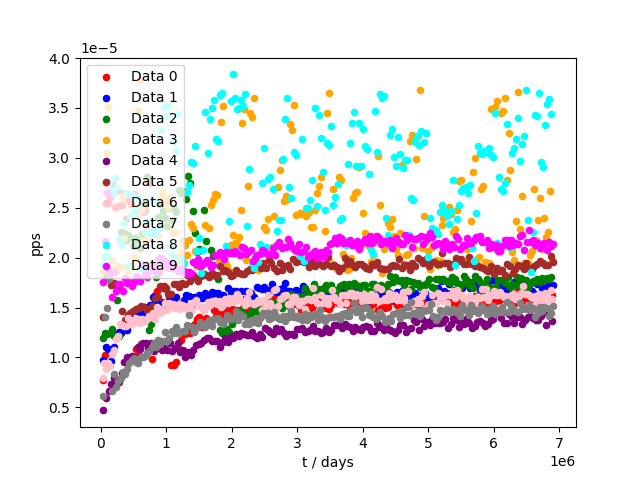

Below is a single example of a single market session with its hyperparameters which was run for 30 days

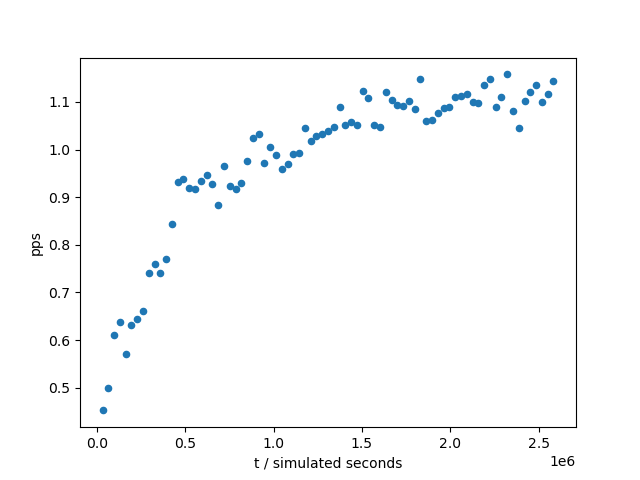

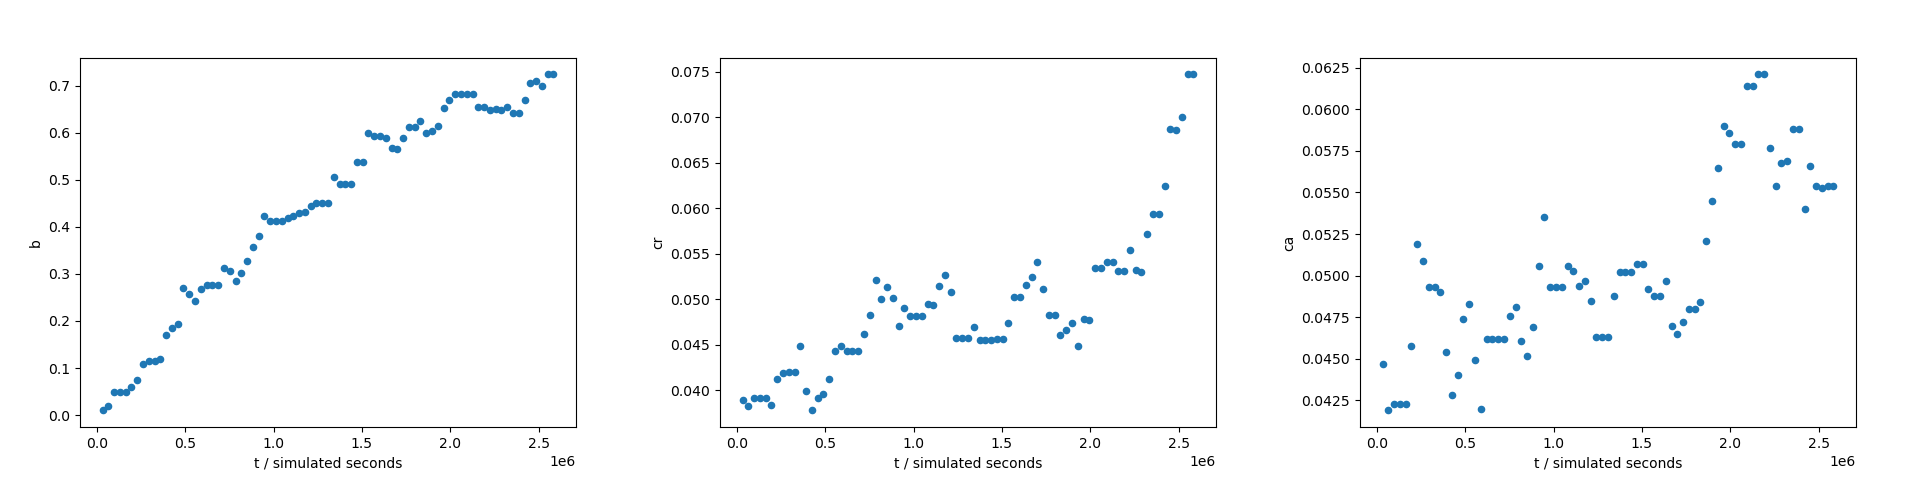

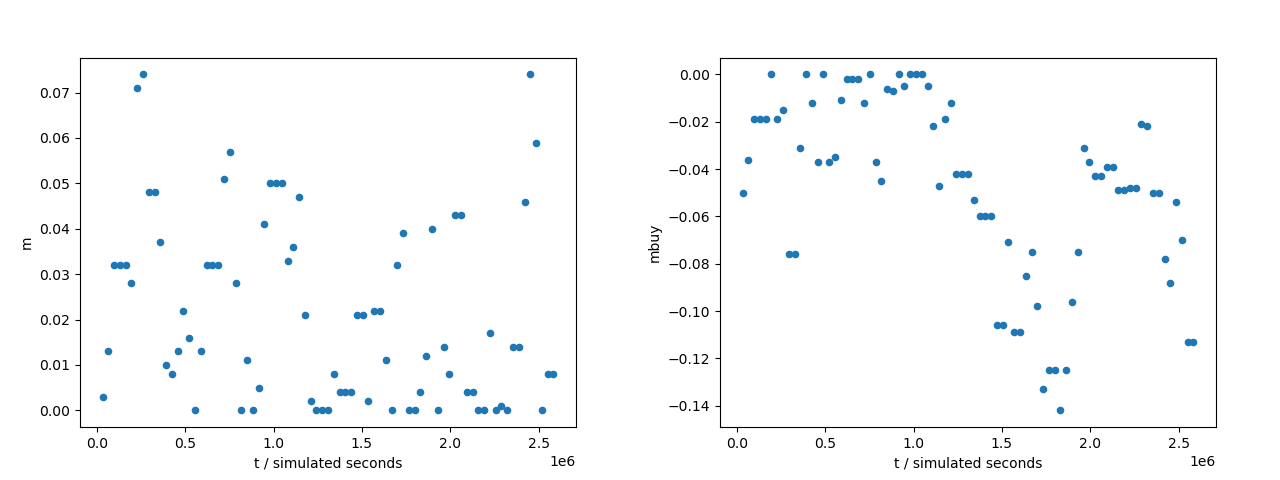

You can see that the learning rate, cr and ca learnt well and has similar correlation to pps. The momentum and mbuy may have not learnt correctly.

### Part D2

#### Tabu Search - ZIPTS

Tabu search is another hill climbing strategy where you find the best solution in your local neighbourhood and which you generate your offspring from. However you don't keep your elite solution in your gene pool. Instead, you maintain a finite list of previously visited places which you cannot return to. Once the list is full, the oldest gene gets removed at which point it is possible to return to it. The larger the list size the more you explore of the fitness landscape. Tabu search is superior when the landscape is more rugged as a steepest ascent hillclimber would get stuck at a local maxima since it is a greedy algorithm as mentionned in the inital brief. Therefore, I thought it would be interesting to compare the behaviour of an explorative and exploitative hill climbers. Below is the generic pseudocode taken from the third year Aritificial Intelligence Unit (Seth Bullock).

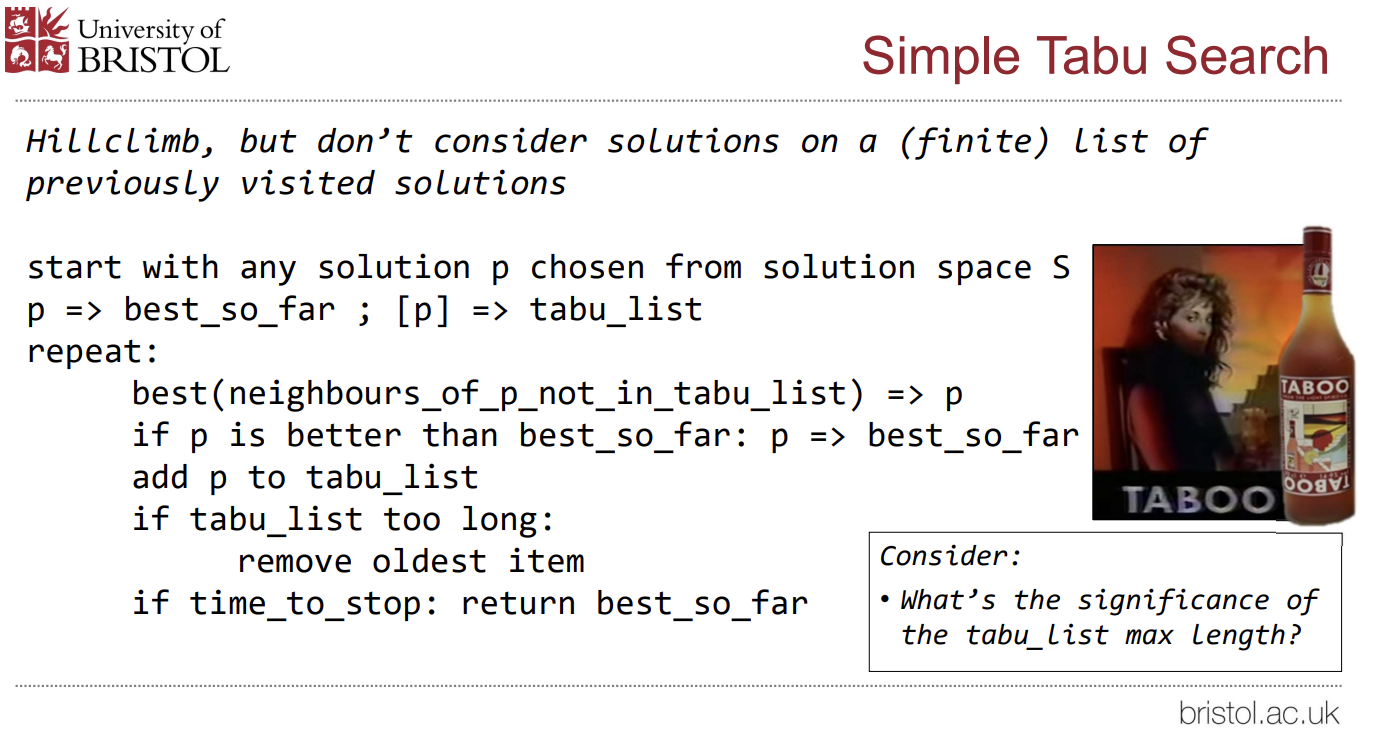

To ensure the tabu search is being fully applied I had ran the market sessions for 80 days to get the full use out of the tabu list. I made the maximum length of the list equal to 20. Since $k=4$ we ensure that there will be no repeats for 5 generations. To determine if a mutation was a repeat I had a tolerance factor for each of the hyperparameters which was equal to the standard deviation used to mutate it. If the new strategy was within the tolerance for all hyperparmeters when comparing the difference to an old strategy we re-generate it.

In [4]:
buyers = [('ZIC', 9), ('ZIPTS', 1,{'optimizer': 'ZIPTS', 'k': 4})]
sellers = [('ZIC', 10)]
end_time = 60 * 60 * 24 * 80
traders_specs = {'sellers': sellers, 'buyers': buyers}
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]
order_interval = 15
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
              'interval': order_interval, 'timemode': 'periodic'}

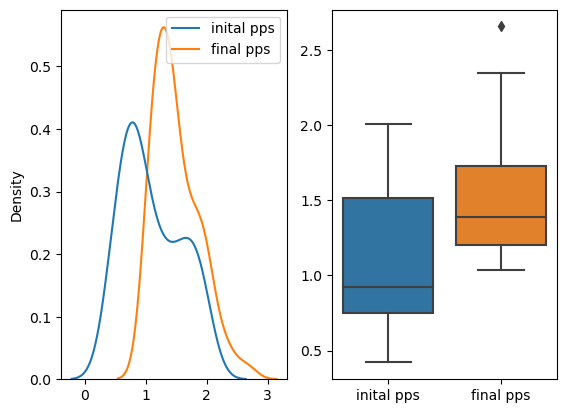

   inital pps normality  final pps normality  All normal  \
0               0.00116             0.000786       False   

                   Test Name       P Value  Different populations  
0  Wilcoxon Signed Rank test  2.696655e-11                   True  


In [5]:
zipts_summary = part_d1(60, (start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)
display(zipts_summary)
plt.show()

We can perform the same method as above for ZIPSH to see if ZIPTS has improved. The step rank test shows that we have sufficient evidence to reject $H_0$ and that ZIPSH has improved over time. 

If we compare the the kde and box plots of the ZIPTS and ZIPSH algorithms we can see that the median value for the ZIPTS trader is lower than the ZIPSH but the Q3 is larger. This may suggest that ZIPTS is not getting stuck as much. Therefore we can plot the scatter plot for 10 market sessiosns using the same seed as for ZIPSH.

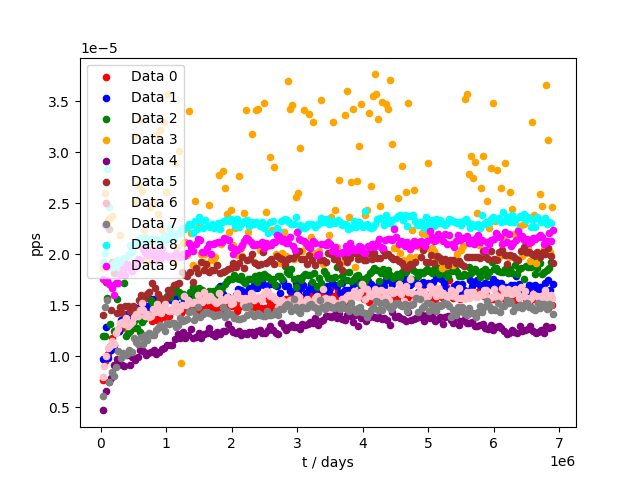

We can see that both GAs have a very similar pps curve. The ZIPTS has less noise than the ZIPSH curve with 'Data 8' being a perfect example of ZIPSH repeatedly climbing up and down the same hill whilst the ZIPTS overcomes the local maximum and continues to learn. However, the majority of the ZIPSH do not get stuck have obtained a slightly larger pps than the ZIPTS by the end.

So, if the ZIPTS is better at the beginning and ZIPSH is better later on then maybe we can mix both?

#### Hybrid Tabu Search Hillclimber - ZIPTSH

ZIPTSH is a hybrid algorithm that starts out using the tabu search and exploring the fitness landscape. At the same time it keeps track of the most elite strategy so far. Then after 70% of the time has elapsed it will swap to using steepest hillclimber and loading in the most elite strategy to mutate. 

In [5]:
buyers = [('ZIC', 9), ('ZIPTSH', 1,{'optimizer': 'ZIPTS', 'k': 4})]
sellers = [('ZIC', 10)]
traders_specs = {'sellers': sellers, 'buyers': buyers}
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]
order_interval = 15
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
              'interval': order_interval, 'timemode': 'periodic'}

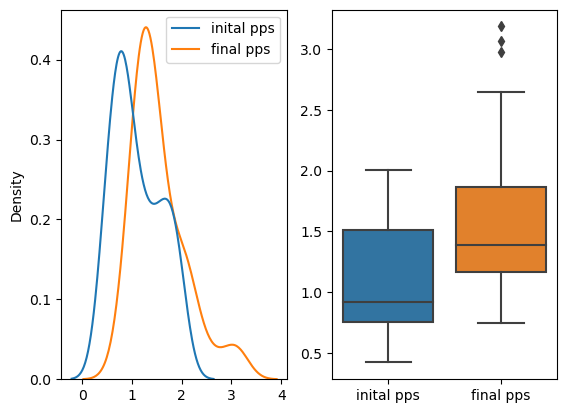

   inital pps mean  inital pps std  final pps mean  final pps std  All normal  \
0         1.102288        0.478551        1.545581       0.544172       False   

                   Test Name       P Value  Different populations  
0  Wilcoxon Signed Rank test  7.633193e-11                   True  


In [6]:
ziptsh_summary = part_d1(60, (start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)
display(ziptsh_summary)
plt.show()

The kde plot shows the final pps distrubution has been slightly shifted, when compared with ZIPTS, with another small peak at 3pps. Which is similar to what was seen in ZIPSH. We can show 10 scatterplots again.

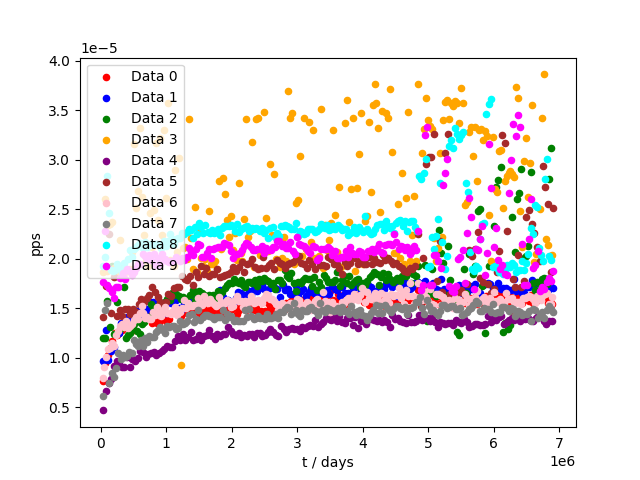

The beginning of the plot is identical to the ZIPTS, since we have used the same seed. At 50 days we see some curves begin to sharply rise and the rest are reaching a turning point. This indicates that the simulation was not run long enough. Regardless we can look at a pps plt for each side by side.

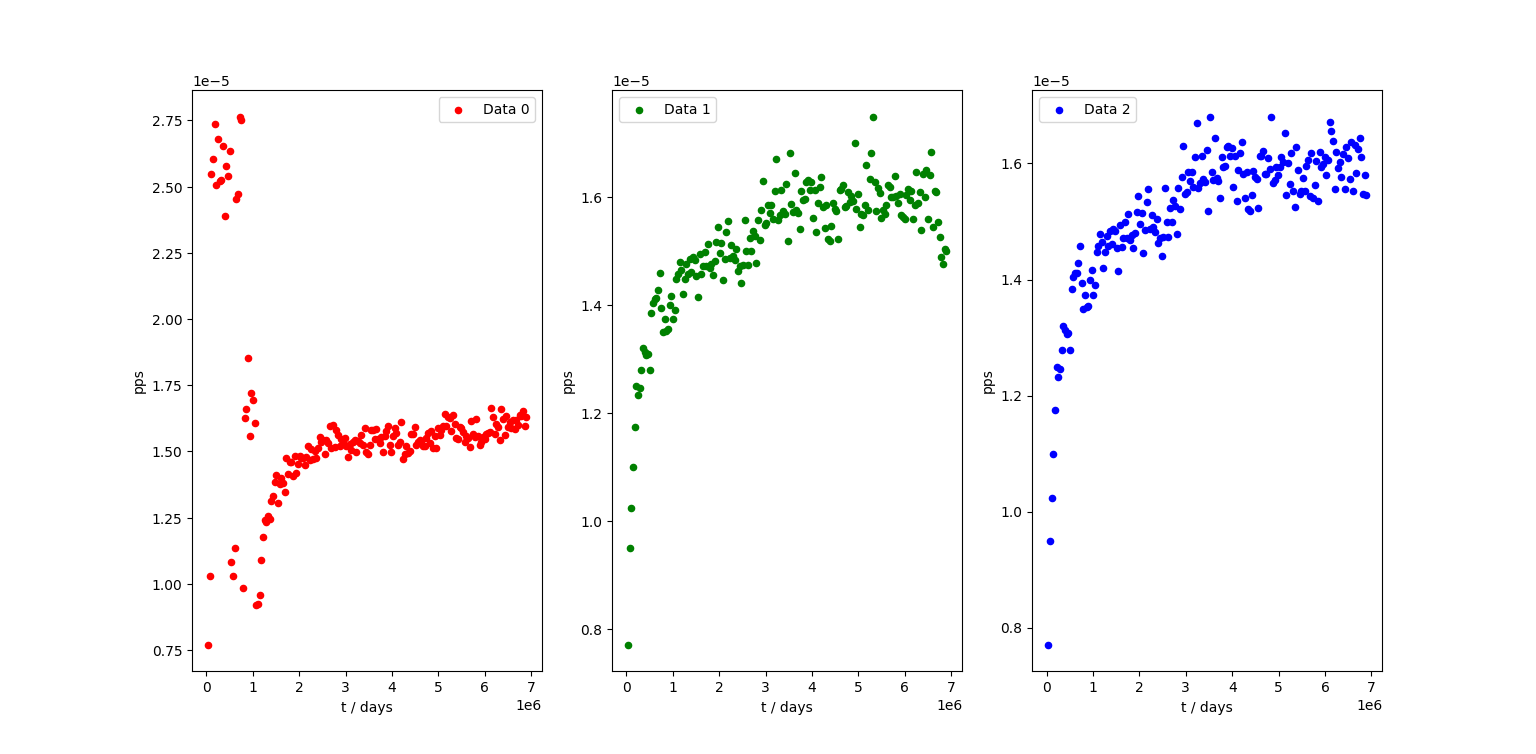

In this example the ZIPTSH (blue) improves well throuoghout and seems to outperform ZIPSH (red) and ZIPTS (green).

# BSE Changes

Average balances dump to remove logs and run quicker. Changed ZIC class to have my GAs and initial ZIPSH parameters. Changed stategy dump to work. Same with populate market, unpack params. Changed file name to BSE_tabu_restart.py because not enough time for version control.

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT.

In [6]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

In [7]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "cw.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 1998. Limit is 2000 words.
